In [61]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
with open('form5500_data/config.json') as f:
   conf = json.load(f)
   host = conf['host']
   database = conf['database']
   user = conf['user']
   passw = conf['passw']

In [3]:
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)

In [4]:
conn = psycopg2.connect(conn_str)

In [7]:
query = "SELECT sb.SB_TOT_PARTCP_CNT, sb.SB_PLAN_AT_RISK_IND, sb.SB_EFF_INT_RATE_PRCNT, sb.SB_PLAN_YEAR_BEGIN_DATE, sb.SB_FNDNG_SHORT_IND, \
       sb.SB_PR_YR_FNDNG_PRCNT, sb.SB_FNDNG_TGT_PRCNT, sb.SB_TOT_FNDNG_TGT_AMT, sb.SB_CURR_VALUE_AST_01_AMT, \
       sb.SB_PLAN_TYPE_CODE \
FROM sb_full sb \
WHERE sb.SB_PLAN_YEAR_BEGIN_DATE BETWEEN '2017-01-01' AND '2017-12-31';"

In [8]:
eda_df = pd.read_sql(query, con=conn)

In [9]:
eda_df

,sb_tot_partcp_cnt,sb_plan_at_risk_ind,sb_eff_int_rate_prcnt,sb_plan_year_begin_date,sb_fndng_short_ind,sb_pr_yr_fndng_prcnt,sb_fndng_tgt_prcnt,sb_tot_fndng_tgt_amt,sb_curr_value_ast_01_amt,sb_plan_type_code
0,3,None,5.26,2017-01-01,1,97.07,112.68,269963.0,304208.0,1
1,2,None,5.72,2017-01-01,2,117.40,121.43,1853763.0,2251205.0,1
2,6,None,5.72,2017-01-01,2,110.49,108.27,375766.0,406872.0,1
3,17,None,5.87,2017-01-01,1,85.28,92.24,974043.0,1220713.0,1
4,1,None,5.24,2017-01-01,1,92.60,94.72,2385087.0,2259335.0,1
5,2,None,4.16,2017-01-01,2,101.21,104.45,702486.0,733755.0,1
6,2,None,4.30,2017-01-01,2,146.27,142.65,1003627.0,1431693.0,1
7,2,0,5.72,2017-01-01,2,89.01,100.87,233957.0,236013.0,1
8,1,None,5.64,2017-01-01,1,82.17,80.00,747025.0,620933.0,1
9,4,0,5.63,2017-01-01,2,111.76,103.29,2870545.0,2965011.0,1


<h3>Add calculated FS (using MVA instead of AVA) column</h3>

In [10]:
eda_df['mva_fs'] = eda_df['sb_curr_value_ast_01_amt'] / eda_df['sb_tot_fndng_tgt_amt'] *100

<h3>Add year column (year only of plan year begin date) </h3>

In [11]:
eda_df['plan_year_dt'] = pd.to_datetime(eda_df['sb_plan_year_begin_date'])

In [12]:
eda_df['year'] = eda_df['plan_year_dt'].dt.year

<h3>Create integer versions of feature columns</h3>

<h3>Participant count</h3>

In [13]:
eda_df['ptp_cnt'] = pd.to_numeric(eda_df['sb_tot_partcp_cnt'])

<h3>Prior year shortfall indicator</h3>

In [14]:
eda_df['sb_fndng_short_ind'].unique()

array(['1', '2', None], dtype=object)

In [15]:
eda_df['sf_ind'] = pd.to_numeric(eda_df['sb_fndng_short_ind'])
eda_df['sf_ind'] = eda_df['sf_ind'].fillna(value=0)

<h1>Create Features DF</h1>
<h3>Drop rows with NA</h3>

In [16]:
prelim_feat_df = eda_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'year','sf_ind', \
                         'sb_pr_yr_fndng_prcnt', 'sb_tot_fndng_tgt_amt','mva_fs', \
                          'sb_plan_type_code','sb_fndng_tgt_prcnt']]

In [17]:
prelim_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17139 entries, 0 to 17138
Data columns (total 9 columns):
ptp_cnt                  17120 non-null float64
sb_eff_int_rate_prcnt    17121 non-null float64
year                     17139 non-null int64
sf_ind                   17139 non-null float64
sb_pr_yr_fndng_prcnt     16994 non-null float64
sb_tot_fndng_tgt_amt     17126 non-null float64
mva_fs                   15703 non-null float64
sb_plan_type_code        17139 non-null object
sb_fndng_tgt_prcnt       17128 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.2+ MB


In [18]:
prelim_feat_df

,ptp_cnt,sb_eff_int_rate_prcnt,year,sf_ind,sb_pr_yr_fndng_prcnt,sb_tot_fndng_tgt_amt,mva_fs,sb_plan_type_code,sb_fndng_tgt_prcnt
0,3.0,5.26,2017,1.0,97.07,269963.0,112.685072,1,112.68
1,2.0,5.72,2017,2.0,117.40,1853763.0,121.439742,1,121.43
2,6.0,5.72,2017,2.0,110.49,375766.0,108.278024,1,108.27
3,17.0,5.87,2017,1.0,85.28,974043.0,125.324344,1,92.24
4,1.0,5.24,2017,1.0,92.60,2385087.0,94.727572,1,94.72
5,2.0,4.16,2017,2.0,101.21,702486.0,104.451192,1,104.45
6,2.0,4.30,2017,2.0,146.27,1003627.0,142.651902,1,142.65
7,2.0,5.72,2017,2.0,89.01,233957.0,100.878794,1,100.87
8,1.0,5.64,2017,1.0,82.17,747025.0,83.120779,1,80.00
9,4.0,5.63,2017,2.0,111.76,2870545.0,103.290873,1,103.29


In [19]:
prelim_feat_df = prelim_feat_df.dropna(axis=0)

In [20]:
y_ava_fs = prelim_feat_df['sb_fndng_tgt_prcnt'].values
y_fs = prelim_feat_df['mva_fs'].values
y_ft = prelim_feat_df['sb_tot_fndng_tgt_amt'].values

In [21]:
X = prelim_feat_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'sf_ind', \
                         'sb_pr_yr_fndng_prcnt']]

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 17138
Data columns (total 4 columns):
ptp_cnt                  15634 non-null float64
sb_eff_int_rate_prcnt    15634 non-null float64
sf_ind                   15634 non-null float64
sb_pr_yr_fndng_prcnt     15634 non-null float64
dtypes: float64(4)
memory usage: 610.7 KB


<h1>Features EDA</h1>

In [23]:
from pandas.plotting import scatter_matrix

In [24]:
X2 = prelim_feat_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'sf_ind', \
                         'sb_pr_yr_fndng_prcnt', 'sb_fndng_tgt_prcnt', \
                          'sb_plan_type_code']]

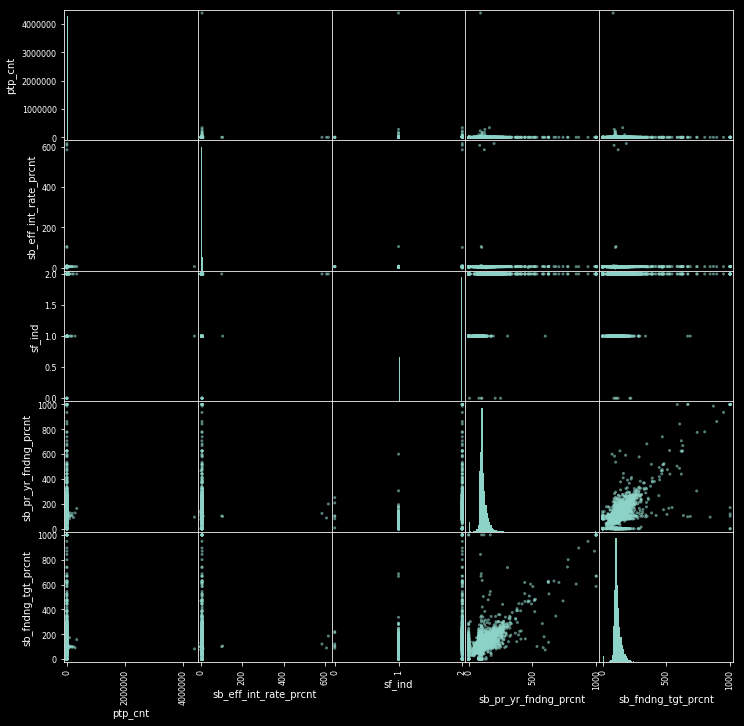

In [25]:
plt.style.use(['dark_background'])
scatter_matrix(X2, alpha=0.6, figsize=(12, 12), diagonal='hist', hist_kwds={'bins':100})
plt.show()

<h3>EIR - restrict to values between 1 and 10 (appear to be invalid data entries)</h3>

In [26]:
X2[X2['ptp_cnt']<=100].describe()

,ptp_cnt,sb_eff_int_rate_prcnt,sf_ind,sb_pr_yr_fndng_prcnt,sb_fndng_tgt_prcnt
count,15008.000000,15008.000000,15008.000000,15008.000000,15008.000000
mean,12.073494,5.739227,1.737540,112.185325,119.191327
std,15.975363,7.116170,0.440894,49.553327,50.221827
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.550000,1.000000,94.860000,100.000000
50%,6.000000,5.740000,2.000000,103.845000,110.555000
75%,13.000000,5.910000,2.000000,123.092500,129.760000
max,100.000000,617.000000,2.000000,999.990000,999.990000


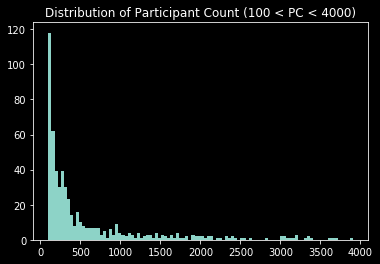

In [28]:
plt.hist(X2[(X2['ptp_cnt']<4000) & (X2['ptp_cnt']>100)]['ptp_cnt'],bins=100)
plt.title('Distribution of Participant Count (100 < PC < 4000)')
plt.show()

In [41]:
eir_nonzero = X2[(X2['sb_eff_int_rate_prcnt'] >1) & (X2['sb_eff_int_rate_prcnt'] < 10) \
                & (X2['sb_fndng_tgt_prcnt'] > 0) & (X2['sb_fndng_tgt_prcnt'] < 400) & (X2['sb_plan_type_code'] == '1')]
y_eirnonzero = eir_nonzero['sb_fndng_tgt_prcnt'].values

In [30]:
eir_nonzero.shape, y_eirnonzero.shape, eir_nonzero['sb_eff_int_rate_prcnt'].shape

((15537, 6), (15537,), (15537,))

In [53]:
eir_nonzero['sb_eff_int_rate_prcnt'].describe()

count    15364.000000
mean         5.655298
std          0.521114
min          2.230000
25%          5.580000
50%          5.750000
75%          5.920000
max          8.250000
Name: sb_eff_int_rate_prcnt, dtype: float64

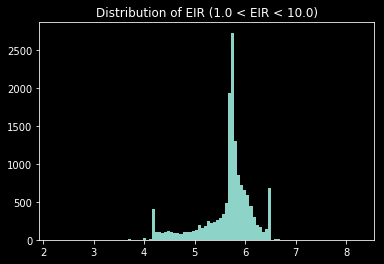

In [42]:
plt.hist(eir_nonzero['sb_eff_int_rate_prcnt'],bins=100)
plt.title('Distribution of EIR (1.0 < EIR < 10.0)')
plt.show()

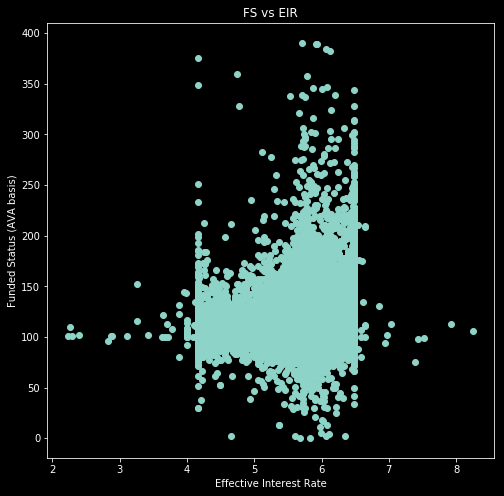

In [43]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
#plt.scatter(X['sb_pr_yr_fndng_prcnt'], y_fs)
plt.scatter(eir_nonzero['sb_eff_int_rate_prcnt'], y_eirnonzero)
plt.xlabel('Effective Interest Rate')
plt.ylabel('Funded Status (AVA basis)')
plt.title('FS vs EIR')
plt.show()

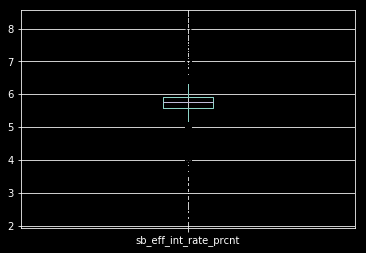

In [60]:
pd.DataFrame(eir_nonzero['sb_eff_int_rate_prcnt']).boxplot(sym=)
plt.show()

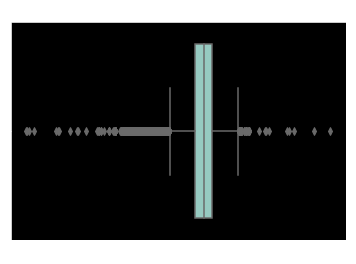

In [64]:
sns.boxplot(pd.DataFrame(eir_nonzero['sb_eff_int_rate_prcnt']))
plt.title('Boxplot of EIR')
plt.show()

In [58]:
eir_nonzero['sb_eff_int_rate_prcnt'].describe()

count    15364.000000
mean         5.655298
std          0.521114
min          2.230000
25%          5.580000
50%          5.750000
75%          5.920000
max          8.250000
Name: sb_eff_int_rate_prcnt, dtype: float64

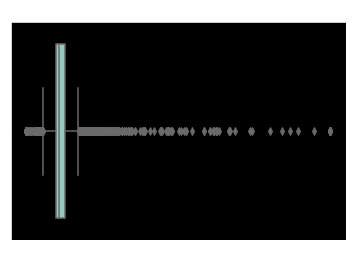

In [67]:
sns.boxplot(prelim_feat_df['sb_fndng_tgt_prcnt'])
plt.title('Boxplot of FS - all plans')
plt.show()

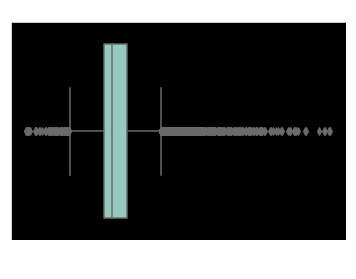

In [69]:
sns.boxplot(eir_nonzero['sb_fndng_tgt_prcnt'])
plt.title('Boxplot of FS (0<FS<400%)')
plt.show()